---
### Multivariate Linear Regression
---

#### Machine learning multivariate linear regression model in Python, using scikit-learn library
---
* Prepare the data.
* Engineer features with some measure of volatility, price and volume. 
* Visualize the feature-target correlation.
* Create the train and test dataset and apply a linear regression algorithm. 
* Identify the performance of the model and plot the results.

---
#### Data Preparation
---

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt 
from datetime import datetime
from sklearn.linear_model import LinearRegression

In [2]:
# Load data
data = pd.read_csv('StockData.csv')

# Format date from object to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Set date as index
data.set_index('Date', inplace = True)

# Arrange oldest to newest
data.sort_values('Date', ascending = True)

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,3.991400e+09,1132.989990
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,2.491020e+09,1136.520020
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,4.972660e+09,1137.140015
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,5.270680e+09,1141.689941
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,4.389590e+09,1144.979980
...,...,...,...,...,...,...
2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883
2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010
2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117


---
#### Generate features
---

We will generate the following features of the model:

* High – Low percent change
* Exponential Moving Average
* Standard deviation of the price 
* Daily volume percent change
* Average volume for the period
* Volume over close price ratio

In [3]:
duration = 3
data['HighLow_pct'] = (data['High'] - data['Low']).pct_change()
data['ExpMovAvg'] = data['Close'].ewm(span = duration).mean().shift(periods = 1)
data['Std'] = data['Close'].rolling(center = False, window = duration).std().shift(periods = 1)
data['VolChange'] = data['Volume'].pct_change()
data['VolAvg'] = data['Volume'].rolling(center = False, window = duration).mean().shift(periods = 1)
data['VolClose'] = data['Volume'].rolling(center = False, window = duration).std().shift(periods = 1)

---
#### Visualise & Inspect Correlations
---

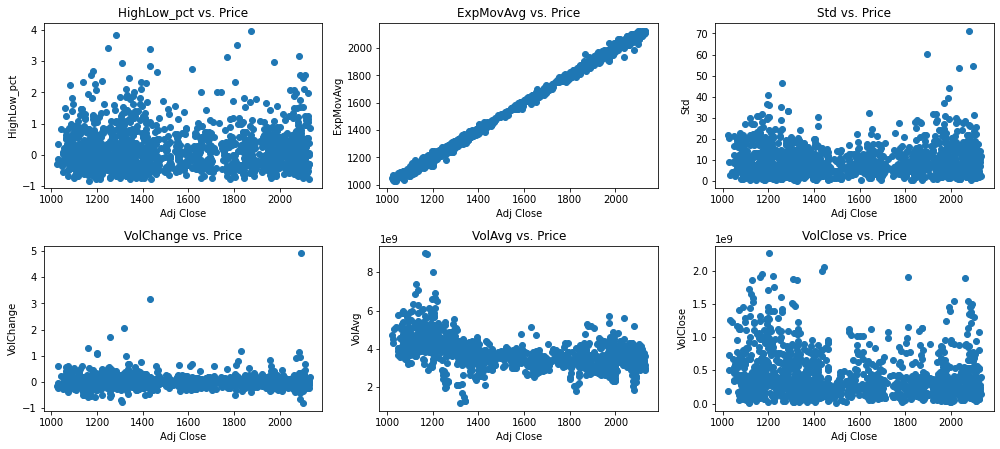

HighLow_pct   -0.010328
ExpMovAvg      0.998842
Std            0.065144
VolChange     -0.005446
VolAvg        -0.460698
VolClose      -0.220982
Name: Adj Close, dtype: float64

In [4]:
# Build plots
def correlation(df, variables, n_rows, n_cols):
    fig = plt.figure(figsize = (14,9))
    for i, var in enumerate(variables):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        asset = df.loc[:, var]
        ax.scatter(df['Adj Close'], asset)
        ax.set_xlabel('Adj Close')
        ax.set_ylabel('{}'.format(var))
        ax.set_title(var + ' vs. Price')
    fig.tight_layout()
    plt.show()

variables = data.columns[-6:]
correlation(data, variables, 3, 3)

# Corrlation Matrix
data.corr()['Adj Close'].loc[variables]

Adj Close:
* Very highly correlated with the  Exponential Moving Average variable. 
* Negative correlation with the volume average for 5 days and volume to Close ratio.


---
#### Data Preprocessing and Machine Learning Application
---

In [5]:
# Identify null values
data.isnull().sum().loc[variables]

# Remove nulls
data = data.dropna(axis = 0)

# Train & test data
train = data[data.index < datetime(year = 2015, month = 1, day = 1)]
test = data[data.index >= datetime(year = 2015, month = 1, day = 1)]

x_test = test[['HighLow_pct', 'ExpMovAvg', 'Std', 'VolChange', 'VolAvg', 'VolClose']].values
y_test = test['Adj Close'].values

x_train = train[['HighLow_pct', 'ExpMovAvg', 'Std', 'VolChange', 'VolAvg', 'VolClose']]
y_train = train['Adj Close']

# Build the model
model = LinearRegression()
model.fit(x_train, y_train)
dates = test.index

Mean Error:  15.73


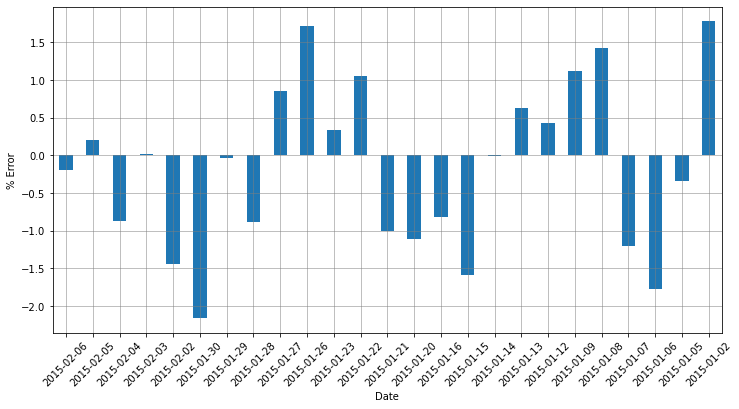

In [6]:
# Predict Adj Close using x_test data
close_pred = model.predict(x_test)

# Calculate MSE
error = sum(abs(close_pred - test['Adj Close'].values)) / test.shape[0]
print('Mean Error: ', error.round(2))

# Plot the error term for the last 25 days 
period = 25
df = pd.DataFrame({'Date':dates, 'Actual':y_test, 'Predicted':close_pred})
df1 = df.tail(period)

#Format date & set index for plot
df1['Date'] = df1['Date'].dt.strftime('%Y-%m-%d')
df1.set_index('Date', inplace = True)

#Plot the error over period
error1 = 100 * (df1['Actual'] - df1['Predicted']) / df1['Actual']
error1.plot(kind = 'bar', figsize = (12,6))

plt.grid(which = 'major', linestyle = '-', linewidth = '0.5', color = 'grey')
plt.grid(which = 'minor', linestyle = ':', linewidth = '0.5', color = 'grey')

plt.xticks(rotation = 45)
plt.ylabel('% Error')
plt.show();